<a href="https://colab.research.google.com/github/davidmo-3549/david_mo_portfolio/blob/main/Neural_Network_Model_David_Mo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Model Demo




In this demonstration, I will be applying a Neural Network algorithm to the commonly used California Housing dataset.

The goal is to train a prediction model that can identify the different classes under the "ocean_proximity" variable (NEAR BAY, INLAND, etc.)

## Setup

Install packages and establish our working environment

In [ ]:
pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install tensorflow

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Data

Load and inspect the data

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [ ]:
housing["ocean_proximity"].value_counts()

# analyse the distribution of the classes in ocean_proximity

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}

housing['ocean_proximity_index'] = housing['ocean_proximity'].map(ocean_proximity_mapping)

# for our purposes, establishing an index for ocean_proximity is useful as it is easier to perform this type of analysis on int64 data as opposed to strings.

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              20640 non-null  float64
 1   latitude               20640 non-null  float64
 2   housing_median_age     20640 non-null  float64
 3   total_rooms            20640 non-null  float64
 4   total_bedrooms         20433 non-null  float64
 5   population             20640 non-null  float64
 6   households             20640 non-null  float64
 7   median_income          20640 non-null  float64
 8   median_house_value     20640 non-null  float64
 9   ocean_proximity        20640 non-null  object 
 10  ocean_proximity_index  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
housing["ocean_proximity_index"].value_counts()

,count
ocean_proximity_index,
0,9136
1,6551
2,2658
3,2290
4,5


In [ ]:
X = housing.drop(columns=['ocean_proximity', 'ocean_proximity_index'])

# drop these as these are the "y" variables

In [ ]:
# establish training, validation, and testing sets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test = train_test_split(X, random_state=42)
y_train_full, y_test = train_test_split(housing["ocean_proximity_index"], random_state=42)             # establish "ocean_proximity_index" as the y variable

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
X_train_full.shape

# This is the shape we expected, which shows us that we are in good order to proceed to our analysis.

# The train-test split by default places 75% of the data in the training set. 75% of 20640 observations is 15480.
# the number of X variables we have is 9.

(15480, 9)

## Neural Network Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define the model

model = keras.models.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=X_train.shape[1:]),         # define the input layer
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(5, activation="softmax")                                        # 5 neurons for the 5 catefories in ocean_proximity. The "softmax" activation function is used here for its utility in classifiaction.
])

# the number of neurons and model complexity is kept modest due to computing power limitations.
# The model should still be powerful enough for demonstrative purposes.

In [ ]:
# estimate the model

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=("sgd"),
              metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)                 # only the model with the best validation performance will be kept
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

# To avoid overfitting, I am including an "early stopping" mechanism with a patience of 10 in this model.
# This means that if there are 10 successive iterations in which there is no improvement, then training will automatically stop and
# the weights from the best performing epoch will be kept.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 500)                 │           5,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,405 (235.96 KB)

 Trainable params: 60,405 (235.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5172 - loss: 1.3439 - val_accuracy: 0.6840 - val_loss: 0.8863
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7061 - loss: 0.8379 - val_accuracy: 0.7517 - val_loss: 0.6869
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7541 - loss: 0.6760 - val_accuracy: 0.7752 - val_loss: 0.5952
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7765 - loss: 0.5921 - val_accuracy: 0.7881 - val_loss: 0.5373
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7921 - loss: 0.5336 - val_accuracy: 0.8026 - val_loss: 0.4894
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8080 - loss: 0.4848 - val_accuracy: 0.8269 - val_loss: 0.4454
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8291 - loss: 0.4400 - val_accuracy: 0.8421 - val_loss: 0.4054
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8440 - loss: 0.4011 - val_accu

Saving figure keras_learning_curves_plot


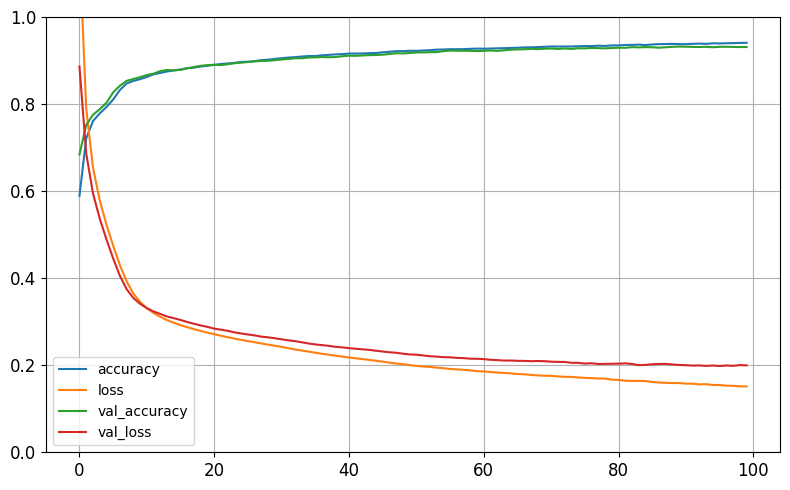

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

# The early stopping mechanism did not activate
# Our lowest val_loss is in the 96thth epoch and is 0.1982.
# This isn't particularly low, but it is close to the training loss of 0.1531, which is a good sign that we are not overfitting.

# The val_accuracy in 96th epoch is 0.9315, which is also close to the training accuracy of 0.9401.

# On thing to note though is that the while the accuracy of the training and validation sets remain colse, the gap in the loss functions begins to grow at higher epochs.
# Although the early stopping mechanism did not activate, these results suggest that we reached the point where any further training/ increasing epochs would likely lead to some overfitting.

# Overall, the accuracy and loss function performance was mediocre, but we successfully avoided overfitting.

In [ ]:
model.evaluate(X_test, y_test)

# Our accuracy on the testing set is 0.8551. This isn't particularly high, and differs from the training accuracy more than the validation accuracy does.
# This suggests that there actually may indeed be some slight overfitting.

# Further fine-tuning to this model is needed, and can be achieved through adding complexity/ increasing layers to the model.

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: nan


[nan, 0.9131782650947571]

In [ ]:
# Let's test the accuracy of our predictions by comparing the precidtions in our testing split to the actual values in the original dataset
# We'll be looking at the first 10 observations in the testing set.

y_new = y_test[:10]
y_new

,ocean_proximity_index
20046,1
3024,1
15663,3
20484,0
9814,2
13311,1
7113,0
7668,0
18246,3
5723,0


In [ ]:
# predictions are
# 1. Inland
# 2. Inland
# 3. Near Bay
# 4. <1H Ocean
# 5. Near Ocean
# 6. Inland
# 7. <1H Ocean
# 8. <1H Ocean
# 9. Near Bay
# 10. <1H Ocean

In [ ]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
obs1 = housing.loc[[20046, 3024, 15663, 20484, 9814, 13311, 7113, 7668, 18246, 5723], "ocean_proximity"]
print(obs1)

20046        INLAND
3024         INLAND
15663      NEAR BAY
20484     <1H OCEAN
9814     NEAR OCEAN
13311        INLAND
7113      <1H OCEAN
7668      <1H OCEAN
18246      NEAR BAY
5723      <1H OCEAN
Name: ocean_proximity, dtype: object


In [ ]:
# At least for these 10 observations, our predictions were all correct.